In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from giggle.data import (
    DATASETS,
)

from giggle.recommender import (
    load_recommender,
)

In [3]:
# Helper functions
def read_file(path):
    with open(path, 'r') as f:
        return f.read()
    
DATA_PATH = '../data'

def get_joke_path(joke_id):
    return os.path.join(DATA_PATH, 'jokes', str(joke_id) + '.txt')

In [4]:
# Load data
dataset = DATASETS["large"]()

# Baseline recommender

Implements a model of the form $b_{ui} = \mu + b_u + b_i,$ where:

* $b_{ui}$ is the baseline estimate for rating $r_{ui}$
* $b_u$ and $b_i$ indicate the observed deviations of user $u$ and item $i$
* $\mu$ is the average rating

In [20]:
reco = load_recommender("../data/models/baseline.pkl")

## Baselines for jokes

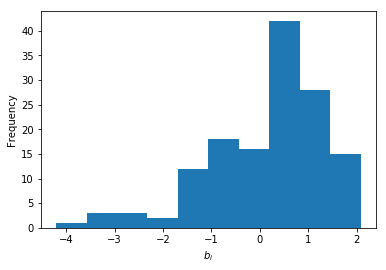

In [21]:
b_joke = list(reco.b_joke.values())
plt.hist(b_joke)
plt.xlabel('$b_i$')
plt.ylabel('Frequency')

### Funniest joke

In [23]:
most_funny_joke_id = max(reco.b_joke, key=reco.b_joke.get)
print("ID:", most_funny_joke_id, reco.b_joke[most_funny_joke_id])
print()
print(read_file(get_joke_path(most_funny_joke_id)))

ID: 32 2.08146720532

A man arrives at the gates of heaven. St. Peter asks, "Religion?" The man says, "Methodist." St. Peter looks down his list, and says, "Go to room 24, but be very quiet as you pass room 8."

Another man arrives at the gates of heaven. "Religion?" "Baptist." "Go to room 18, but be very quiet as you pass room 8."

A third man arrives at the gates. "Religion?" "Jewish." "Go to room 11, but be very quiet as you pass room 8." The man says, "I can understand there being different rooms for different religions, but why must I be quiet when I pass room 8?" St. Peter tells him, "Well, the Catholics are in room 8, and they think they're the only ones here."


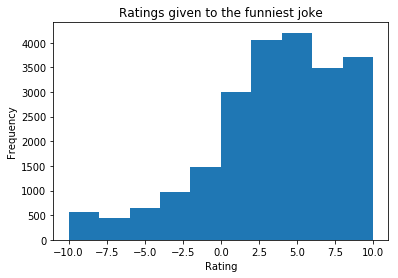

In [24]:
idxs = dataset.data_frame.joke_id == most_funny_joke_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given to the funniest joke')

### Least funny joke

In [25]:
least_funny_joke_id = min(reco.b_joke, key=reco.b_joke.get)
print("ID:", least_funny_joke_id, reco.b_joke[least_funny_joke_id])
print()
print(read_file(get_joke_path(least_funny_joke_id)))

ID: 7 -4.20780054398

How many feminists does it take to screw in a light bulb?

That's not funny.


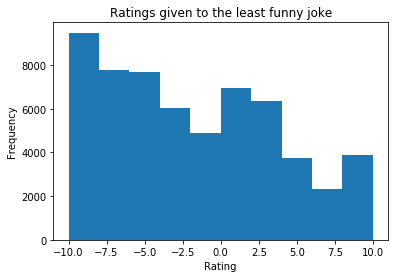

In [26]:
idxs = dataset.data_frame.joke_id == least_funny_joke_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given to the least funny joke')

# Baselines for users

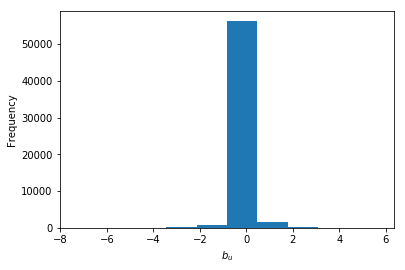

In [11]:
b_user = list(reco.b_user.values())
plt.hist(b_user)
plt.xlabel('$b_u$')
plt.ylabel('Frequency')

### Most indulgent user

6112 5.71700397969


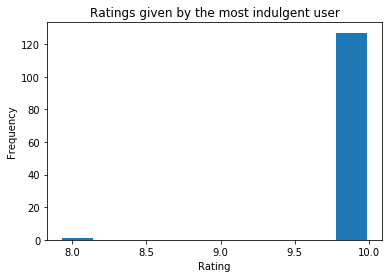

In [12]:
most_indulgent_user_id = max(reco.b_user, key=reco.b_user.get)
print(most_indulgent_user_id, reco.b_user[most_indulgent_user_id])
idxs = dataset.data_frame.user_id == most_indulgent_user_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given by the most indulgent user')

### Most critical user

1751 -7.38091455803


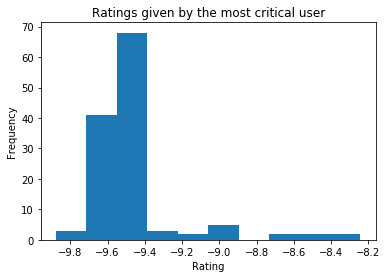

In [13]:
most_critical_user_id = min(reco.b_user, key=reco.b_user.get)
print(most_critical_user_id, reco.b_user[most_critical_user_id])
idxs = dataset.data_frame.user_id == most_critical_user_id
plt.hist(dataset.data_frame[idxs].rating)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings given by the most critical user')

# Item-based neighbourhood model

The item-based neighbourhood model predicts the rating a user $u$ would give to a new joke $j$ based on the similarity of that joke to the other jokes that $u$ has rated. The similarity between two jokes $i$ and $j$ is computed based on how similar the ratings across the users are: the more the ratings agree, the higher the similarity.

In [14]:
reco = load_recommender("../data/models/neigh.pkl")

-0.73341043033 1.0


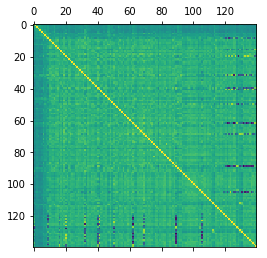

In [15]:
print(reco.sims.min(), reco.sims.max())
plt.matshow(reco.sims)

In [18]:
iid = reco.data.joke_to_iid[most_funny_joke_id]
idxs = np.argsort(-reco.sims[iid])
idxs = idxs[1:6]
for i in idxs:
    print("ID:", i, reco.sims[i, iid])
    print()
    print(read_file(get_joke_path(i)))
    print()

ID: 95 0.479949029164

Just a thought...

Before criticizing someone, walk a mile in their shoes.

Then, when you do criticize them, you will be a mile away and have their shoes!

ID: 43 0.475774722956

Arnold Schwarzenegger and Sylvester Stallone are making a movie about the lives of the great composers.

Stallone says, "I want to be Mozart."

Swartzeneger says, "In that case...I'll be Bach."

ID: 115 0.463663263779

A lady bought a new Lexus. It cost a bundle. Two days later, she brought it back, complaining that the radio was not working.

"Madam," said the sales manager, "the audio system in this car is completely automatic. All you need to do is tell it what you want to listen to, and you will hear exactly that!"

She drove out, somewhat amazed and a little confused. She looked at the radio and said, "Nelson." The radio responded, "Ricky or Willie?" She was astounded. If she wanted Beethoven, that's what she got. If she wanted Nat King Cole, she got it.

She was stopped at a traff

# Performance comparison

| Method | Fold 1 | Fold 2 | Fold 3 | Average RMSE |
|--|
| Guassian | 7.50 | 7.51 | 7.51 | 7.51 ± 0.001 |
| Beta | 7.62 | 7.61 | 7.62 | 7.62 ± 0.003 |
| Baseline | 5.04 | 5.00 | 4.89 | 4.98 ± 0.039 |
| Neighbourhood | 4.30 | 4.31 | 4.31 | 4.31 ± 0.002 |

Results obtained using the following bash script:

```bash
for r in gaussian beta baseline neigh; do
    giggle evaluate -d large -r beta -v
done
```